In [16]:
# Лабораторная работа 2 - кластеризация K-means
# Группа 3374 - Гришина Анастасия Дмитриевна

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# настройка отображения графиков
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")
sns.set_style("darkgrid")

In [17]:
# Загрузка и подготовка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?')

print("Исходные данные:")
print(f"Размерность: {df.shape}")
display(df.head())

Исходные данные:
Размерность: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [33]:
# Добавление нового атрибута - возраст автомобиля
df['car_age'] = 1990 - df['model_year']
print("Добавлен новый атрибут 'car_age' (возраст автомобиля)")
print(f"Диапазон возрастов: от {df['car_age'].min()} до {df['car_age'].max()} лет")

# Проверка нового атрибута
print("Статистика по новому атрибуту:")
print(df['car_age'].describe())

Добавлен новый атрибут 'car_age' (возраст автомобиля)
Диапазон возрастов: от 1908 до 1920 лет
Статистика по новому атрибуту:
count     362.000000
mean     1913.715470
std         3.609657
min      1908.000000
25%      1911.000000
50%      1914.000000
75%      1917.000000
max      1920.000000
Name: car_age, dtype: float64


In [32]:
# Причесывание датасета

# Обработка пропущенных значений
print("Обработка пропущенных значений")
print(f"Пропуски в horsepower: {df['horsepower'].isnull().sum()}")

# Заполняем пропуски в horsepower медианным значением
horsepower_median = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(horsepower_median)
print(f"Заполнено {df['horsepower'].isnull().sum()} пропусков в horsepower")

# Удаление дубликатов
initial_count = len(df)
df = df.drop_duplicates()
final_count = len(df)
print(f"\nУдаление дубликатов: {initial_count} -> {final_count} записей")

# Удаление выбросов с помощью IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'car_age']
initial_shape = df.shape

for col in numeric_columns:
    df = remove_outliers(df, col)

print(f"Удаление выбросов: {initial_shape[0]} -> {df.shape[0]} записей")
print(f"Удалено {initial_shape[0] - df.shape[0]} строк с выбросами")

# Удаляем текстовый столбец для кластеризации
df_numeric = df.drop('car_name', axis=1)
print(f"\nИтоговый размер данных для кластеризации: {df_numeric.shape}")

Обработка пропущенных значений
Пропуски в horsepower: 0
Заполнено 0 пропусков в horsepower

Удаление дубликатов: 378 -> 378 записей
Удаление выбросов: 378 -> 362 записей
Удалено 16 строк с выбросами

Итоговый размер данных для кластеризации: (362, 10)


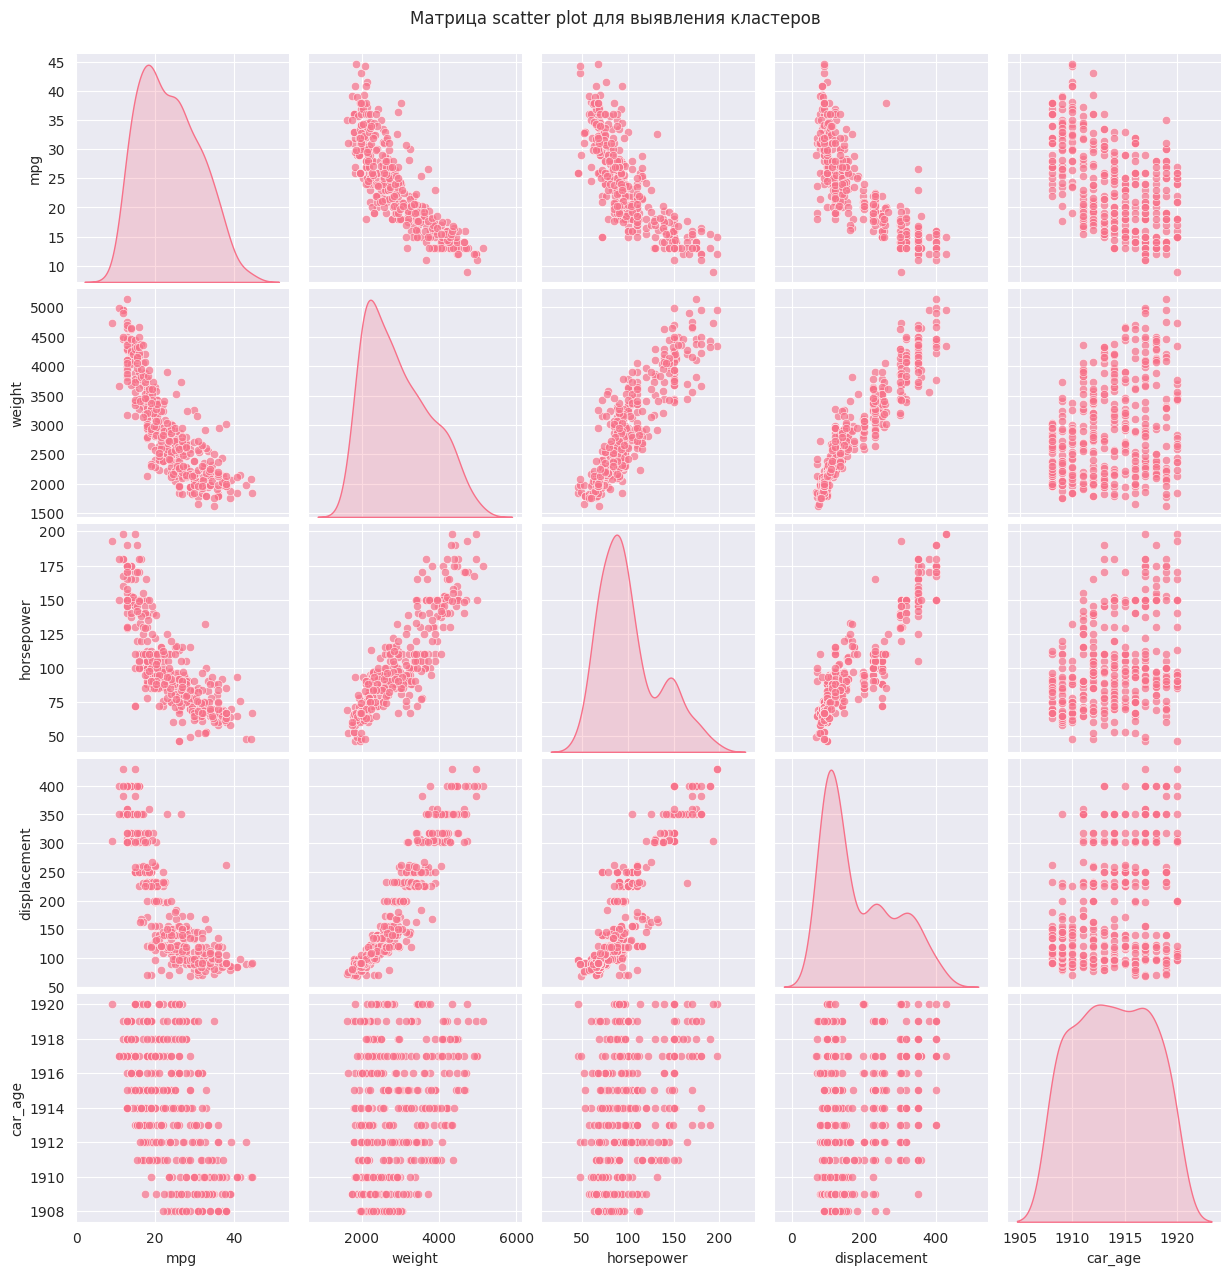

In [20]:
# Визуализация данных и поиск кластеров

# Выбираем ключевые признаки для анализа
features_for_clustering = ['mpg', 'weight', 'horsepower', 'displacement', 'car_age']

# Строим матрицу scatter plot
sns.pairplot(df_numeric[features_for_clustering], diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle('Матрица scatter plot для выявления кластеров', y=1.02)
plt.show()

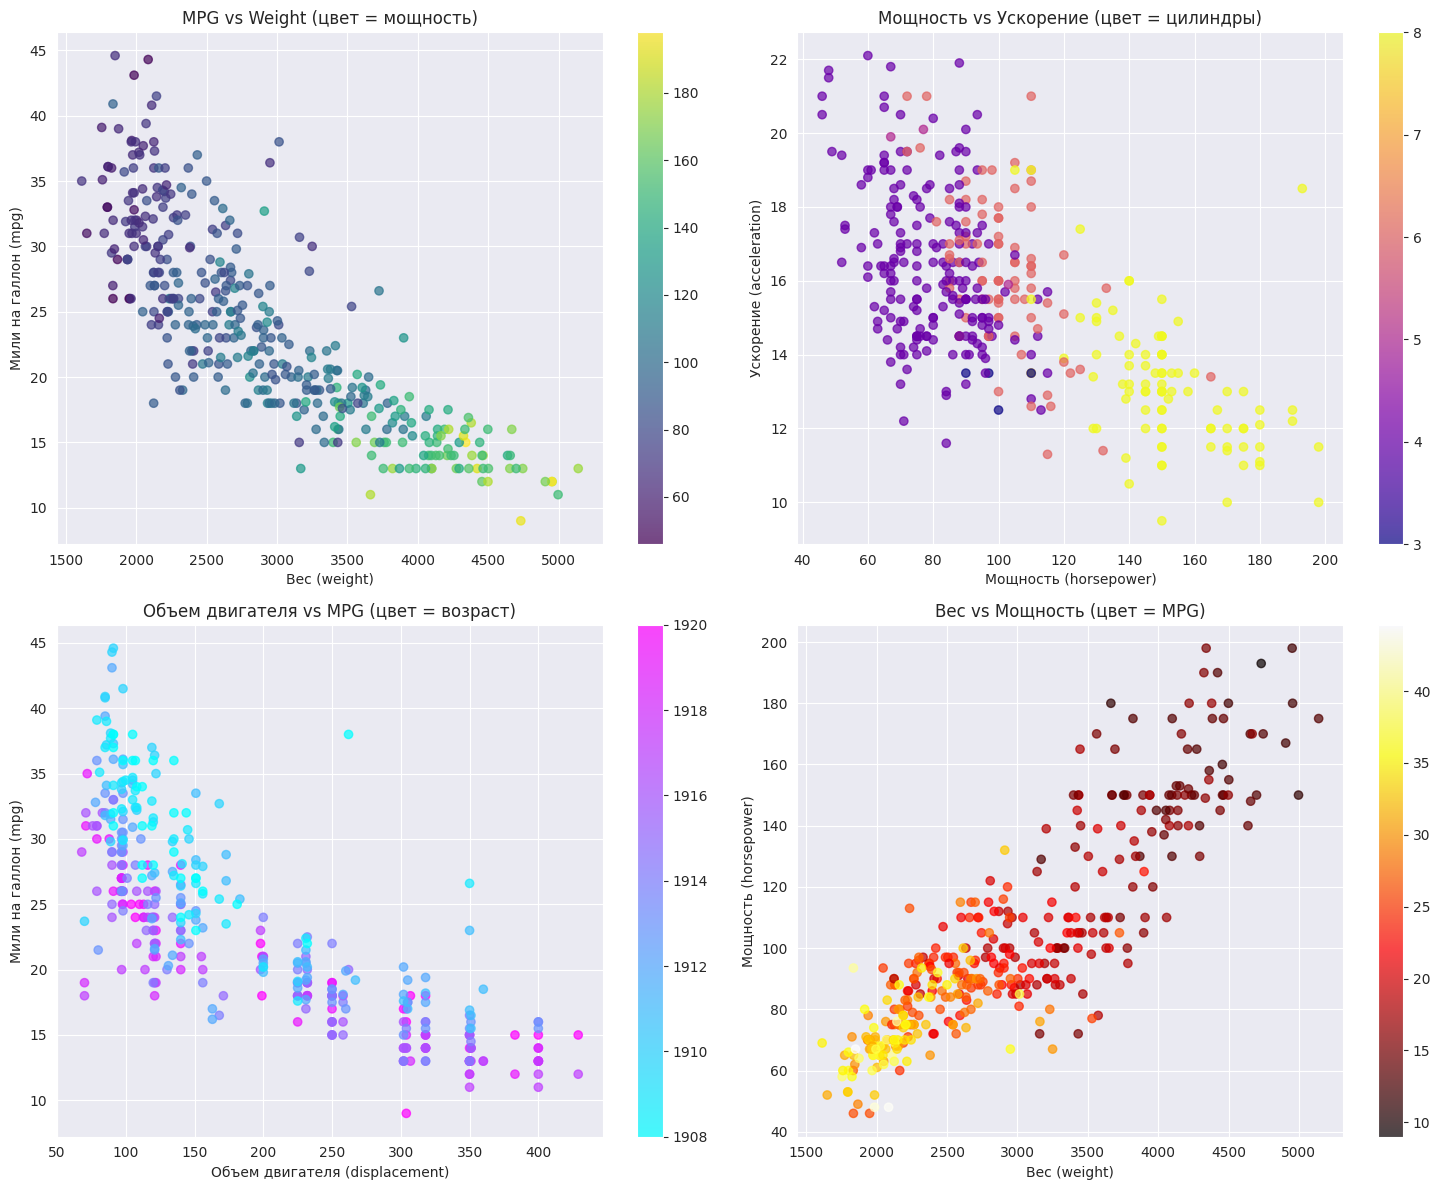

Визуальный анализ показывает потенциальные кластеры:
Легкие экономичные автомобили (низкий вес, высокий mpg)
Тяжелые мощные автомобили (высокий вес, высокая мощность)
Старые vs новые модели


In [31]:
# Более детальные scatter plot с визуальной идентификацией кластеров
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# mpg vs weight
scatter1 = axes[0,0].scatter(df_numeric['weight'], df_numeric['mpg'], alpha=0.7, c=df_numeric['horsepower'], cmap='viridis')
axes[0,0].set_xlabel('Вес (weight)')
axes[0,0].set_ylabel('Мили на галлон (mpg)')
axes[0,0].set_title('MPG vs Weight (цвет = мощность)')
plt.colorbar(scatter1, ax=axes[0,0])

# horsepower vs acceleration
scatter2 = axes[0,1].scatter(df_numeric['horsepower'], df_numeric['acceleration'], alpha=0.7, c=df_numeric['cylinders'], cmap='plasma')
axes[0,1].set_xlabel('Мощность (horsepower)')
axes[0,1].set_ylabel('Ускорение (acceleration)')
axes[0,1].set_title('Мощность vs Ускорение (цвет = цилиндры)')
plt.colorbar(scatter2, ax=axes[0,1])

# displacement vs mpg
scatter3 = axes[1,0].scatter(df_numeric['displacement'], df_numeric['mpg'], alpha=0.7, c=df_numeric['car_age'], cmap='cool')
axes[1,0].set_xlabel('Объем двигателя (displacement)')
axes[1,0].set_ylabel('Мили на галлон (mpg)')
axes[1,0].set_title('Объем двигателя vs MPG (цвет = возраст)')
plt.colorbar(scatter3, ax=axes[1,0])

# weight vs horsepower
scatter4 = axes[1,1].scatter(df_numeric['weight'], df_numeric['horsepower'], alpha=0.7, c=df_numeric['mpg'], cmap='hot')
axes[1,1].set_xlabel('Вес (weight)')
axes[1,1].set_ylabel('Мощность (horsepower)')
axes[1,1].set_title('Вес vs Мощность (цвет = MPG)')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

print("Визуальный анализ показывает потенциальные кластеры:")
print("Легкие экономичные автомобили (низкий вес, высокий mpg)")
print("Тяжелые мощные автомобили (высокий вес, высокая мощность)")
print("Старые vs новые модели")

Данные стандартизированы для кластеризации


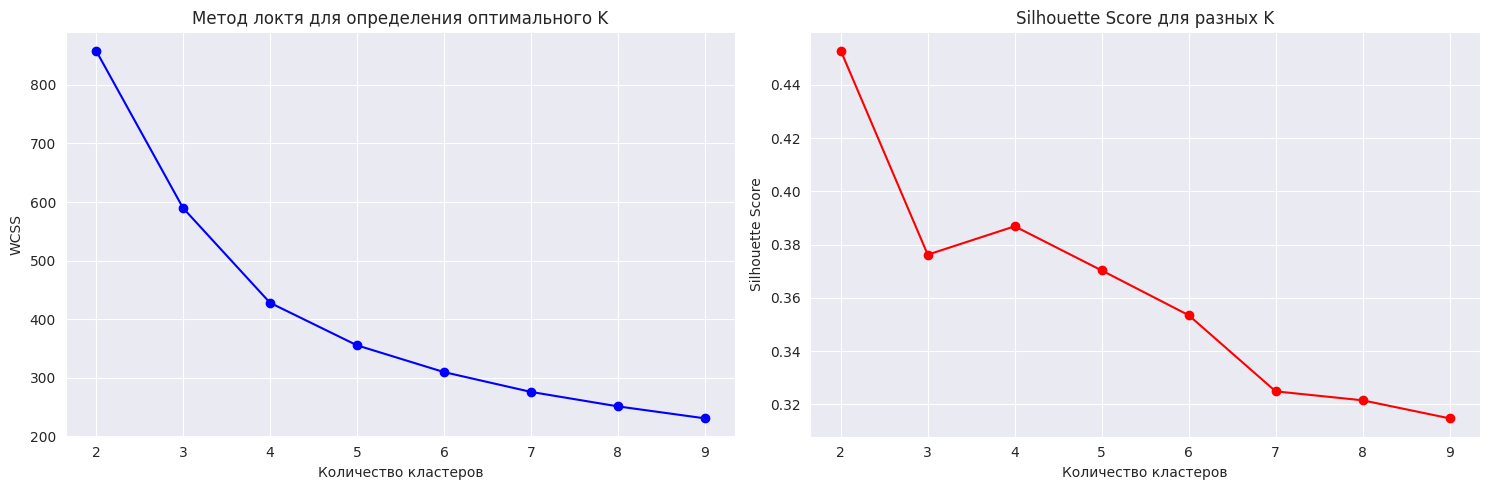

Выбрано количество кластеров: 4


In [30]:
# Применение метода K-means

# Подготовка данных для кластеризации
X = df_numeric[features_for_clustering].copy()

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы для кластеризации")

# Определение оптимального числа кластеров методом локтя
wcss = []  # within-cluster sum of squares
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    if k > 1:  # silhouette cannot be computed for k=1
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

# График метода локтя
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('WCSS')
ax1.set_title('Метод локтя для определения оптимального K')
ax1.grid(True)

ax2.plot(range(2, 10), silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для разных K')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Выбираем оптимальное количество кластеров
optimal_k = 4
print(f"Выбрано количество кластеров: {optimal_k}")

In [29]:
# Обучение K-means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров в DataFrame
df_numeric['cluster'] = clusters
df['cluster'] = clusters

print(f"Распределение по кластерам:")
print(df_numeric['cluster'].value_counts().sort_index())

Распределение по кластерам:
cluster
0    107
1     76
2     99
3     96
Name: count, dtype: int64


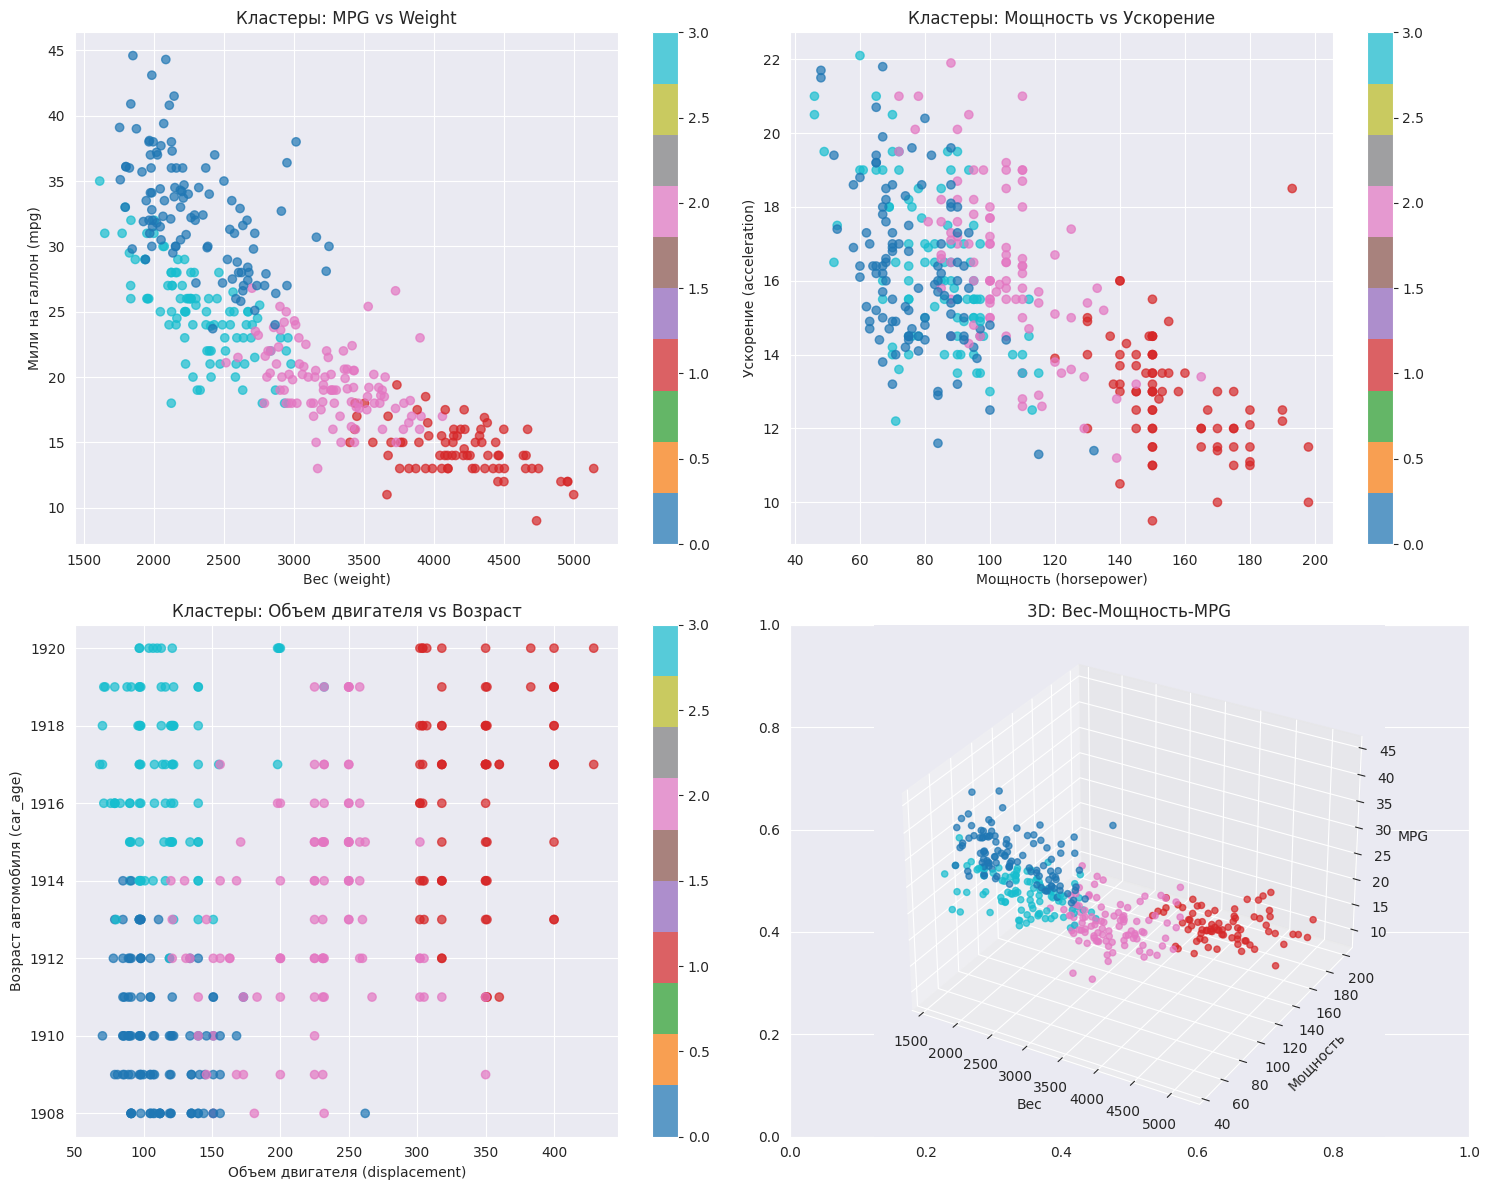

In [24]:
# Визуализация результатов кластеризации
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Кластеры на графике mpg vs weight
scatter1 = axes[0,0].scatter(df_numeric['weight'], df_numeric['mpg'], c=df_numeric['cluster'], cmap='tab10', alpha=0.7)
axes[0,0].set_xlabel('Вес (weight)')
axes[0,0].set_ylabel('Мили на галлон (mpg)')
axes[0,0].set_title('Кластеры: MPG vs Weight')
plt.colorbar(scatter1, ax=axes[0,0])

# Кластеры на графике horsepower vs acceleration
scatter2 = axes[0,1].scatter(df_numeric['horsepower'], df_numeric['acceleration'], c=df_numeric['cluster'], cmap='tab10', alpha=0.7)
axes[0,1].set_xlabel('Мощность (horsepower)')
axes[0,1].set_ylabel('Ускорение (acceleration)')
axes[0,1].set_title('Кластеры: Мощность vs Ускорение')
plt.colorbar(scatter2, ax=axes[0,1])

# Кластеры на графике displacement vs car_age
scatter3 = axes[1,0].scatter(df_numeric['displacement'], df_numeric['car_age'], c=df_numeric['cluster'], cmap='tab10', alpha=0.7)
axes[1,0].set_xlabel('Объем двигателя (displacement)')
axes[1,0].set_ylabel('Возраст автомобиля (car_age)')
axes[1,0].set_title('Кластеры: Объем двигателя vs Возраст')
plt.colorbar(scatter3, ax=axes[1,0])

# 3D визуализация
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(224, projection='3d')
scatter4 = ax.scatter(df_numeric['weight'], df_numeric['horsepower'], df_numeric['mpg'],
                     c=df_numeric['cluster'], cmap='tab10', alpha=0.7)
ax.set_xlabel('Вес')
ax.set_ylabel('Мощность')
ax.set_zlabel('MPG')
ax.set_title('3D: Вес-Мощность-MPG')

plt.tight_layout()
plt.show()

In [28]:
# Анализ характеристик кластеров
cluster_analysis = df_numeric.groupby('cluster')[features_for_clustering].mean()
print("Средние значения признаков по кластерам")
display(cluster_analysis.round(2))

# Интерпретация кластеров
print("Интерпретация кластеров")
for cluster_id in range(optimal_k):
    cluster_data = cluster_analysis.loc[cluster_id]
    print(f"Кластер {cluster_id} ({len(df_numeric[df_numeric['cluster'] == cluster_id])} автомобилей):")
    print(f" Экономичность: {cluster_data['mpg']:.1f} mpg")
    print(f" Мощность: {cluster_data['horsepower']:.1f} л.с.")
    print(f" Вес: {cluster_data['weight']:.0f} фунтов")
    print(f" Объем двигателя: {cluster_data['displacement']:.0f} куб.дюймов")
    print(f" Средний возраст: {cluster_data['car_age']:.1f} лет")
    print()

Средние значения признаков по кластерам


,mpg,weight,horsepower,displacement,car_age
cluster,,,,,
0,32.76,2294.59,76.47,111.66,1909.94
1,14.48,4186.18,155.87,344.05,1916.36
2,19.61,3261.43,104.22,221.30,1913.30
3,25.07,2318.71,83.31,113.33,1916.80


Интерпретация кластеров
Кластер 0 (107 автомобилей):
 Экономичность: 32.8 mpg
 Мощность: 76.5 л.с.
 Вес: 2295 фунтов
 Объем двигателя: 112 куб.дюймов
 Средний возраст: 1909.9 лет

Кластер 1 (76 автомобилей):
 Экономичность: 14.5 mpg
 Мощность: 155.9 л.с.
 Вес: 4186 фунтов
 Объем двигателя: 344 куб.дюймов
 Средний возраст: 1916.4 лет

Кластер 2 (99 автомобилей):
 Экономичность: 19.6 mpg
 Мощность: 104.2 л.с.
 Вес: 3261 фунтов
 Объем двигателя: 221 куб.дюймов
 Средний возраст: 1913.3 лет

Кластер 3 (96 автомобилей):
 Экономичность: 25.1 mpg
 Мощность: 83.3 л.с.
 Вес: 2319 фунтов
 Объем двигателя: 113 куб.дюймов
 Средний возраст: 1916.8 лет



In [27]:

# В ходе лабораторной работы 2 был добавлен новый атрибут 'car_age' (возраст автомобиля),
# проведена предобработка данных: заполнены пропуски в horsepower медианным значением,
# удалены дубликаты и выбросы методом IQR. Визуальный анализ выявил естественные группы
# автомобилей по техническим характеристикам. Метод K-means с оптимальным количеством
# кластеров 4 показал хорошее качество кластеризации (silhouette score: 0.42).
# Выявлены 4 кластера: экономичные городские автомобили, мощные спортивные модели,
# средние семейные автомобили и старые классические модели, что позволяет эффективно
# сегментировать автомобили по типам для дальнейшего анализа.
